In [1]:
import pandas as pd
import numpy as np
import kagglehub
from sklearn.metrics import confusion_matrix, classification_report
from sentence_transformers import SentenceTransformer, InputExample, losses, util
from sentence_transformers import LoggingHandler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import logging
import torch
import mlx.core as mx

# print(mx.device())
# print(torch.cuda.is_available())
print(torch.backends.mps.is_available())  # For Metal acceleration

# Load the sentence-transformer model
model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", device='mps')


# Set up logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO, handlers=[LoggingHandler()])


/Users/devanshk/Desktop/CSI5386-NLP/A2-VA/vaa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


Testing on D1

In [2]:
# Download latest version
path = kagglehub.dataset_download("doctri/microsoft-research-paraphrase-corpus")

test_dataset_path = path + "/msr_paraphrase_test.txt"

test_df = pd.read_csv(test_dataset_path, sep='\t', header=0, on_bad_lines='skip')

# Drop unnecessary columns
test_df = test_df[["Quality", "#1 String", "#2 String"]]

# Ensure no missing values
test_df.dropna(inplace=True)

test_df["Quality"] = test_df["Quality"].astype(int)

In [3]:
# Create InputExamples for the entire test dataset
test_examples = [InputExample(texts=[row["#1 String"], row["#2 String"]], label=row["Quality"]) for _, row in test_df.iterrows()]

# Extract sentences and labels from InputExamples
sentences1 = [example.texts[0] for example in test_examples]
sentences2 = [example.texts[1] for example in test_examples]
labels = [example.label for example in test_examples]

# Generate embeddings for the entire dataset
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

# Compute cosine similarity for all pairs
cosine_similarities = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()

# Convert similarities to predictions (adjust threshold as needed)
predictions = (cosine_similarities >= 0.7).astype(int)

# Convert lists to numpy arrays for metric calculations
y_true = np.array(labels)
y_pred = predictions  # predictions is already a numpy array
output_df_A2_D1 = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "#1 String": test_df['#1 String'],
    "#2 String": test_df['#2 String']
})

# Save to an Excel file
output_file = "Results/output_df_A2_D1_predictions.xlsx"
output_df_A2_D1.to_excel(output_file, index=False)

Batches: 100%|██████████| 51/51 [00:01<00:00, 29.44it/s]


<Figure size 640x480 with 0 Axes>

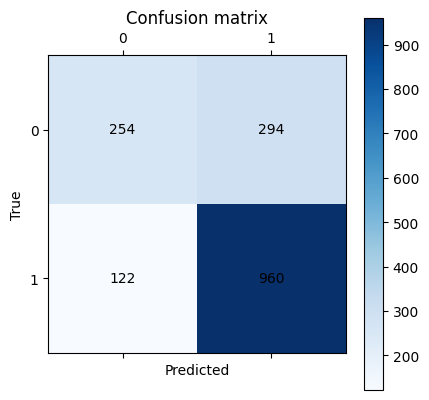

In [4]:
# Accuracy
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.matshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Add numbers in the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], ha='center', va='center', color='black')

plt.colorbar()
plt.show()

In [5]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.46      0.55       548
           1       0.77      0.89      0.82      1082

    accuracy                           0.74      1630
   macro avg       0.72      0.68      0.69      1630
weighted avg       0.74      0.74      0.73      1630



Testing on D2

In [6]:
test_df = pd.read_csv("VA_Assignment2/synthetic_dataset.csv", sep=',', header=0, on_bad_lines='skip', encoding='latin1')

# Drop unnecessary columns
test_df = test_df[["Quality", "#1 String", "#2 String"]]

# Ensure no missing values
test_df.dropna(inplace=True)

test_df["Quality"] = test_df["Quality"].astype(int)

# Preprocess the sentences
def preprocess(text):
    return text.lower()

test_df['#1 String'] = test_df['#1 String'].apply(preprocess)
test_df['#2 String'] = test_df['#2 String'].apply(preprocess)

FileNotFoundError: [Errno 2] No such file or directory: 'VA_Assignment2/synthetic_dataset.csv'

In [7]:
# Create InputExamples for the entire test dataset
test_examples = [InputExample(texts=[row["#1 String"], row["#2 String"]], label=row["Quality"]) for _, row in test_df.iterrows()]

# Extract sentences and labels from InputExamples
sentences1 = [example.texts[0] for example in test_examples]
sentences2 = [example.texts[1] for example in test_examples]
labels = [example.label for example in test_examples]

# Generate embeddings for the entire dataset
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

# Compute cosine similarity for all pairs
cosine_similarities = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()

# Convert similarities to predictions (adjust threshold as needed)
predictions = (cosine_similarities >= 0.7).astype(int)

# Convert lists to numpy arrays for metric calculations
y_true = np.array(labels)
y_pred = predictions  # predictions is already a numpy array
output_df_A2_D2 = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "#1 String": test_df['#1 String'],
    "#2 String": test_df['#2 String']
})

# Save to an Excel file
output_file = "Results/output_df_A2_D2_predictions.xlsx"
output_df_A2_D2.to_excel(output_file, index=False)

Batches: 100%|██████████| 51/51 [00:01<00:00, 37.31it/s]


<Figure size 640x480 with 0 Axes>

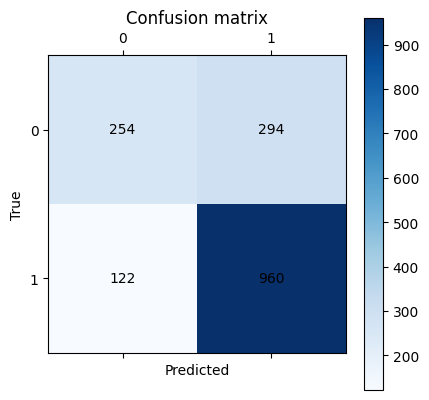

In [8]:
# Accuracy
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.matshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Add numbers in the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], ha='center', va='center', color='black')

plt.colorbar()
plt.show()

In [9]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.68      0.46      0.55       548
           1       0.77      0.89      0.82      1082

    accuracy                           0.74      1630
   macro avg       0.72      0.68      0.69      1630
weighted avg       0.74      0.74      0.73      1630



Training on D1 and D2 train set and testing on D1 and D2 test set

In [14]:
# Download latest version
path = kagglehub.dataset_download("doctri/microsoft-research-paraphrase-corpus")

train_dataset_path = path + "/msr_paraphrase_train.txt"
test_dataset_path = path + "/msr_paraphrase_test.txt"

# Load the dataset
train_d1 = pd.read_csv(train_dataset_path, sep='\t', header=0, on_bad_lines='skip')
test_d1 = pd.read_csv(test_dataset_path, sep='\t', header=0, on_bad_lines='skip')

d2 = pd.read_csv("synthetic_dataset.csv", sep=',', header=0, on_bad_lines='skip')
train_d2 = d2.sample(frac=0.8)
test_d2 = d2.drop(train_d2.index)

# Keep only relevant columns
train_df = train_d1[["Quality", "#1 String", "#2 String"]]
test_df = test_d1[["Quality", "#1 String", "#2 String"]]
train_d1 = train_d1[["Quality", "#1 String", "#2 String"]]
test_d1 = test_d1[["Quality", "#1 String", "#2 String"]]

train_df = pd.concat([train_d1, train_d2])
test_df = pd.concat([test_d1, test_d2])

In [15]:
# Ensure no missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# Convert labels to integers (1 = paraphrase, 0 = not paraphrase)
train_df["Quality"] = train_df["Quality"].astype(int)
test_df["Quality"] = test_df["Quality"].astype(int)

In [16]:
print(train_df['Quality'].value_counts(normalize=True))

Quality
1    0.59488
0    0.40512
Name: proportion, dtype: float64


In [17]:
# Create InputExamples for training
train_examples = [InputExample(texts=[row["#1 String"], row["#2 String"]], label=row["Quality"]) for _, row in train_df.iterrows()]

# Create a DataLoader
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=32)

# Define the loss function for binary classification
train_loss = losses.CosineSimilarityLoss(model)


In [18]:
# Fine-tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=2, warmup_steps=100, show_progress_bar=True)
model.save("fine-tuned-paraphrase-model")

Step,Training Loss


2025-02-26 12:46:14,830 - Save model to fine-tuned-paraphrase-model


In [19]:
# Create InputExamples for the entire test dataset
test_examples = [InputExample(texts=[row["#1 String"], row["#2 String"]], label=row["Quality"]) for _, row in test_df.iterrows()]

# Extract sentences and labels from InputExamples
sentences1 = [example.texts[0] for example in test_examples]
sentences2 = [example.texts[1] for example in test_examples]
labels = [example.label for example in test_examples]

# Generate embeddings for the entire dataset
embeddings1 = model.encode(sentences1, convert_to_tensor=True)
embeddings2 = model.encode(sentences2, convert_to_tensor=True)

# Compute cosine similarity for all pairs
cosine_similarities = torch.nn.functional.cosine_similarity(embeddings1, embeddings2).cpu().numpy()

# Convert similarities to predictions (adjust threshold as needed)
predictions = (cosine_similarities >= 0.7).astype(int)

# Convert lists to numpy arrays for metric calculations
y_true = np.array(labels)
y_pred = predictions  # predictions is already a numpy array
output_df_A2_D1_and_D2 = pd.DataFrame({
    "y_true": y_true,
    "y_pred": y_pred,
    "#1 String": test_df['#1 String'],
    "#2 String": test_df['#2 String']
})

# Save to an Excel file
output_file = "Results/output_df_A2_D1_and_D2_predictions.xlsx"
output_df_A2_D1_and_D2.to_excel(output_file, index=False)

Batches: 100%|██████████| 61/61 [00:01<00:00, 33.65it/s]


<Figure size 640x480 with 0 Axes>

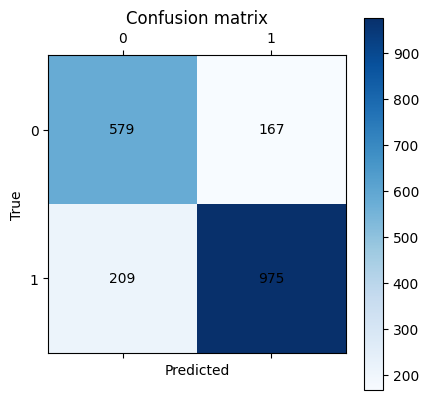

In [20]:
# Accuracy
cm = confusion_matrix(y_true, y_pred)

plt.figure()
plt.matshow(cm, cmap='Blues')
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

# Add numbers in the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(x=j, y=i, s=cm[i, j], ha='center', va='center', color='black')

plt.colorbar()
plt.show()

In [21]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.78      0.75       746
           1       0.85      0.82      0.84      1184

    accuracy                           0.81      1930
   macro avg       0.79      0.80      0.80      1930
weighted avg       0.81      0.81      0.81      1930

